In [1]:
import sys, os, csv
import numpy as np
import pandas as pd
import timeit
import pickle
import theano
import theano.tensor as T

os.chdir(sys.path[0] + "\..")

import yaml

from theano import shared, function
from scipy import stats
from datetime import datetime as dt

from reslogit.models import Logit, ResNet, MLP
from reslogit.core import *
import reslogit.optimizers as optimizers

In [2]:
# constants
FLOATX = theano.config.floatX

# read data file from .csv
raw_data = pd.read_csv(os.getcwd() + '/data/data-20190702_2.csv')

# read configuration file
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
# keep track of time
config['timestamp'] = dt.now().strftime("%Y-%m-%d %H:%M:%S")

# defines the inputs and output
x_data = raw_data.iloc[:, 1:-1]
y_data = raw_data['mode']-1  # -1 for indexing at 0

# defines the list of explanatory variable names
config['variables'] = list(x_data.columns)

# number of observations
config['n_obs'] = raw_data.shape[0] 

# number of variables/choices
config['n_vars'] = x_data.shape[1]
config['n_choices'] = len(config['choices'])

# slicing index for train/valid split
slice = np.floor(0.7*config['n_obs']).astype(int)
config['slice'] = slice

# slices x and y datasets into train/valid
train_x_data, valid_x_data = x_data.iloc[:slice], x_data.iloc[slice:]
train_y_data, valid_y_data = y_data.iloc[:slice], y_data.iloc[slice:]

# load train/valid datasets into shared module
train_x_shared, train_y_shared = shared_dataset(train_x_data, train_y_data)
valid_x_shared, valid_y_shared = shared_dataset(valid_x_data, valid_y_data)

# number of train/valid batches
n_train_batches = train_y_data.shape[0] // config['batch_size']
n_valid_batches = valid_y_data.shape[0] // config['batch_size']
config['n_train_batches'] = n_train_batches
config['n_valid_batches'] = n_valid_batches

# Theano tensor variables
idx = T.lscalar()  # index to [mini]batch
# x = T.matrix('x')
# y = T.ivector('y')

disaggregate point elasticity: [-2.6141251  -1.84300328 -3.7061093  ... -0.5047475  -1.90107521
 -0.40048699]
aggregate point elasticity: -0.962817169767709
[(10, -0.931106599940827), (15, -0.9486953740514056), (20, -0.9609556417837358), (25, -0.9687588449898915), (30, -0.9730742985486839), (35, -0.9748367273982808), (40, -0.9748653039561181), (45, -0.9738287555656922), (50, -0.9722386065671432), (55, -0.9704591364184724), (60, -0.9687278162257812), (65, -0.9671813638118095), (70, -0.9658833567801022), (75, -0.9648493569833531), (80, -0.9640665027564645), (85, -0.9635069193285171), (90, -0.9631360976905053), (95, -0.9629178481047591), (100, -0.962817169767709), (105, -0.9628019305438397), (110, -0.9628438248762919), (115, -0.9629187983579502), (120, -0.9630070417519112), (125, -0.9630926834213261), (130, -0.9631633286171389), (135, -0.9632095628100111), (140, -0.9632244816585257), (145, -0.9632032677241742), (150, -0.9631428142992741), (155, -0.9630413924713828), (160, -0.9628983589250

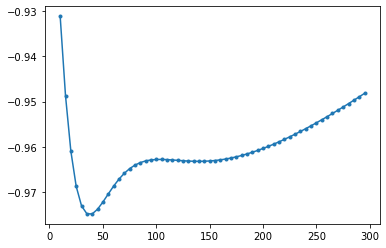

In [3]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 0

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [18.74090032  3.61627035 16.31841714 ... -0.13117156 -0.72411849
  0.31038928]
aggregate point elasticity: 0.9682543105824193
[(10, -0.4723690643032076), (15, -0.5096384586713927), (20, -0.5578611131122581), (25, -0.6199899828947271), (30, -0.6979945628793549), (35, -0.7869756603060671), (40, -0.874564796871752), (45, -0.9556012998214217), (50, -1.0008137441785023), (55, -0.9538115809244866), (60, -0.7293475719644857), (65, -0.24182607285536378), (70, 0.5624329474559424), (75, 1.572606030649555), (80, 2.3520459884602407), (85, 2.637441554258929), (90, 2.359772717243593), (95, 1.581105770787496), (100, 0.9682543105824193), (105, 0.572196548139566), (110, 0.0013496941670168338), (115, -0.5099052139067505), (120, -0.8804156185928904), (125, -1.146463712550191), (130, -1.3335391509298118), (135, -1.4568184218023237), (140, -1.5257682994266144), (145, -1.5543474718995771), (150, -1.5484610993765422), (155, -1.5147794508829238), (160, -1.4558771496284781), (165

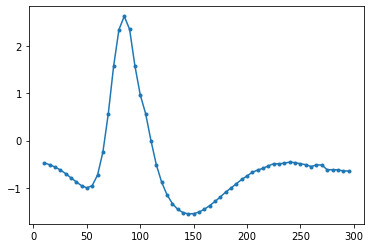

In [4]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 0

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [-0.2539777   1.04563352 -1.14479192 ...  1.3537837   0.43504407
  0.91729713]
aggregate point elasticity: 0.03896866232193789
[(10, -0.028874709461203782), (15, -0.01159079034281936), (20, 0.004515900197258305), (25, 0.01876644537158437), (30, 0.030725801312570827), (35, 0.040215449831049147), (40, 0.047278265953667895), (45, 0.052117740803850586), (50, 0.05503219485834055), (55, 0.05635754986060763), (60, 0.05642538910338874), (65, 0.05553714462540628), (70, 0.05395152922761668), (75, 0.0518812502882091), (80, 0.04949540855096852), (85, 0.04692479975663841), (90, 0.04426822170094105), (95, 0.04159864420941881), (100, 0.03896866232193789), (105, 0.036415044365612485), (110, 0.0339624151975942), (115, 0.03162620174256884), (120, 0.029414970552728167), (125, 0.027332264294740304), (130, 0.025378025219230268), (135, 0.023549682450482737), (140, 0.02184297123053102), (145, 0.02025254264303336), (150, 0.01877241182996822), (155, 0.017396282742321766), (160, 0

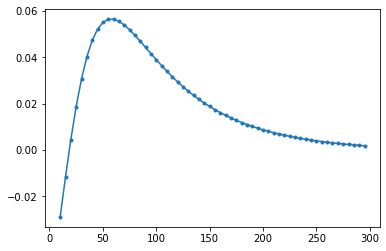

In [5]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 1

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [-15.15907901 -54.04141341  11.34789793 ... -11.15444697 -12.9908034
 -14.03047574]
aggregate point elasticity: -1.517372411343143
[(10, 0.22756157726793833), (15, 0.2605417746182483), (20, 0.30449222099826145), (25, 0.36366226265764084), (30, 0.4402964445018877), (35, 0.5344544297579978), (40, 0.6392583299586406), (45, 0.7558540634851743), (50, 0.8586125126969562), (55, 0.902360170151033), (60, 0.7999613411677282), (65, 0.4325344599498287), (70, -0.31398003446227785), (75, -1.4231573530509174), (80, -2.4524281224020488), (85, -2.982293002827036), (90, -2.8017721772564044), (95, -2.030967529047136), (100, -1.517372411343143), (105, -1.2233987796067698), (110, -0.7201481392083221), (115, -0.3738412837438525), (120, -0.20258952449950177), (125, -0.11566770958886172), (130, -0.06825645488857604), (135, -0.04209576747599777), (140, -0.029765137392747228), (145, -0.020779319026305823), (150, -0.01585707501872127), (155, -0.013720854753786016), (160, -0.0131382

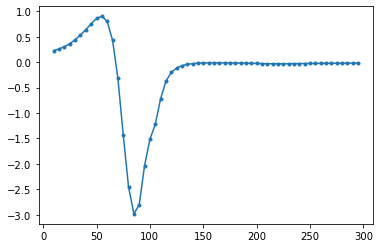

In [6]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 1

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [1.62940164 3.35074332 0.89911952 ... 2.8368772  2.29924917 1.96887866]
aggregate point elasticity: 0.7471501358625776
[(10, 0.2955644166854188), (15, 0.32824584285741387), (20, 0.3621204107208317), (25, 0.3965649689469607), (30, 0.430945065121423), (35, 0.46466997362949164), (40, 0.4972355548485303), (45, 0.5282505382165595), (50, 0.5574451454239295), (55, 0.584663882548209), (60, 0.6098476559338106), (65, 0.6330115825142789), (70, 0.6542234569209422), (75, 0.6735855725313663), (80, 0.6912206077834498), (85, 0.7072611754286002), (90, 0.7218423703214095), (95, 0.7350966201421328), (100, 0.7471501358625776), (105, 0.7581204596527025), (110, 0.7681149264735154), (115, 0.7772300140066088), (120, 0.7855514919114627), (125, 0.793155151307298), (130, 0.8001078418457321), (135, 0.80646858816311), (140, 0.8122896459561635), (145, 0.8176174369485092), (150, 0.8224933504275362), (155, 0.8269544208422802), (160, 0.8310338979007388), (165, 0.834761726452), (170, 0.83

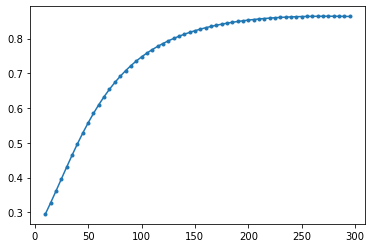

In [7]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 2

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [ 3.34067051 -8.1427856   1.96991195 ...  0.33892895  0.6549634
 -1.63725064]
aggregate point elasticity: 0.22376931744891593
[(10, -0.11368729142986618), (15, -0.10232429493001377), (20, -0.08987826866730993), (25, -0.0768973152867311), (30, -0.0637897536705479), (35, -0.05157319780114127), (40, -0.042145810518578415), (45, -0.04029897047104513), (50, -0.05069199972289032), (55, -0.08244289548904914), (60, -0.14344150956408755), (65, -0.21816088062279188), (70, -0.2664329882366245), (75, -0.21595519013600134), (80, -0.04648647299090528), (85, 0.12552743541549927), (90, 0.17173519409676363), (95, 0.15309941920030437), (100, 0.22376931744891593), (105, 0.29407124102129034), (110, 0.3437158957875132), (115, 0.4918992270308335), (120, 0.681103359028784), (125, 0.8620514142250225), (130, 1.0162720646282695), (135, 1.1392231866733613), (140, 1.2263897351911441), (145, 1.27859432742505), (150, 1.3012524594821215), (155, 1.3035274557074326), (160, 1.280854177741

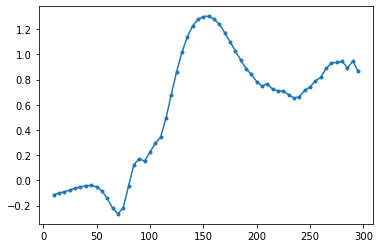

In [8]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 2

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [1.60930956 3.32615218 0.87731487 ... 2.82105541 2.27936164 1.95766028]
aggregate point elasticity: 0.13323315334511093
[(10, 0.6776585812912973), (15, 0.6400043643216619), (20, 0.5967675560306827), (25, 0.5503269847402117), (30, 0.5029098142547225), (35, 0.45637183411860777), (40, 0.4120992965770914), (45, 0.3710085377174185), (50, 0.33360268462214343), (55, 0.3000553347356778), (60, 0.27030050393295796), (65, 0.24411524294179043), (70, 0.22118817001154947), (75, 0.2011709440280661), (80, 0.183712596683961), (85, 0.16847964523949047), (90, 0.15516621252452573), (95, 0.14349802102037293), (100, 0.13323315334511093), (105, 0.12416130629568783), (110, 0.11610221081122526), (115, 0.10890332845818705), (120, 0.1024369075700864), (125, 0.09659666755827288), (130, 0.09129446928743323), (135, 0.08645725368081303), (140, 0.0820243849406889), (145, 0.07794541671057198), (150, 0.07417824063249781), (155, 0.07068756153125243), (160, 0.06744364701646745), (165, 0.064

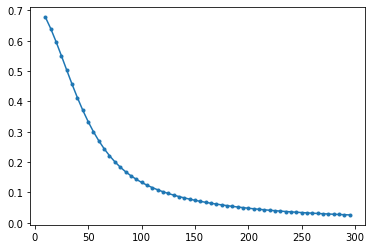

In [9]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 3

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [  0.69585992 -20.78816243 -14.14855488 ...   6.71610126   3.75042314
  -2.15386839]
aggregate point elasticity: 0.032564888039208144
[(10, 0.4134979731961428), (15, 0.4037942607546921), (20, 0.39358702866456047), (25, 0.3828540569175764), (30, 0.3727674395514743), (35, 0.36055784138372476), (40, 0.34399614725085054), (45, 0.32362691810742766), (50, 0.3017063912752833), (55, 0.2751210353682018), (60, 0.24662662254886475), (65, 0.21602406461558568), (70, 0.1828840926726449), (75, 0.15144278472218056), (80, 0.11996472943113509), (85, 0.09372825482044081), (90, 0.06994487566681284), (95, 0.05062062289129234), (100, 0.03256488803920814), (105, 0.014449944690259208), (110, -0.0032493185293380436), (115, -0.020098568773058104), (120, -0.036588338850691564), (125, -0.05240684071473458), (130, -0.06796472105280887), (135, -0.0840466538253432), (140, -0.0971264802220809), (145, -0.10717537455734116), (150, -0.11535662342068113), (155, -0.12709838341998095), (160, 

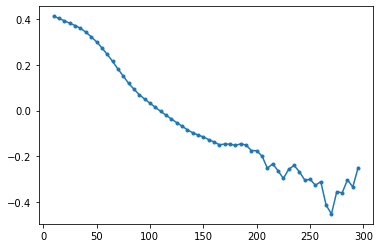

In [10]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 3

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [ 0.16758191  1.5615897  -0.68730016 ...  1.68574674  0.85231189
  1.1526742 ]
aggregate point elasticity: 0.043457943035440955
[(10, 0.00786473556563621), (15, 0.01011737326293713), (20, 0.012590867056173152), (25, 0.01521466467143889), (30, 0.017910383473817355), (35, 0.02060235282401299), (40, 0.023226060749310305), (45, 0.025732815022769903), (50, 0.02809069971361617), (55, 0.030282890952852085), (60, 0.03230460122199847), (65, 0.03415965734604556), (70, 0.03585734806090415), (75, 0.03740990919551342), (80, 0.038830772940095445), (85, 0.04013347553183969), (90, 0.041331016170228996), (95, 0.042435496991852256), (100, 0.043457943035440955), (105, 0.044408241906684624), (110, 0.04529516133162038), (115, 0.046126414191085575), (120, 0.046908749444627154), (125, 0.04764805394046147), (130, 0.0483494550121404), (135, 0.04901741758568408), (140, 0.049655832479194945), (145, 0.050268094662600626), (150, 0.05085717151391459), (155, 0.05142566175823439), (160,

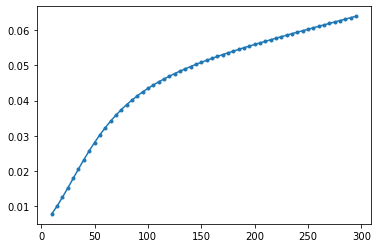

In [11]:
# filename = 'ResNet16_bestmodel.pkl'
filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 4

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()

disaggregate point elasticity: [6.87216398 5.20208714 7.02289132 ... 4.0903095  6.23954955 2.59783608]
aggregate point elasticity: 0.20002937329490353
[(10, -0.020112960111712482), (15, -0.018620404738451005), (20, -0.01803338650578124), (25, -0.01890303910874278), (30, -0.021977983748081496), (35, -0.028141368655336906), (40, -0.03832524627034522), (45, -0.05353568426396613), (50, -0.07364233705069069), (55, -0.09634236367983473), (60, -0.11497221476470516), (65, -0.11666129262264716), (70, -0.08996708789146451), (75, -0.03108356874619899), (80, 0.03773115751417496), (85, 0.09133407166286718), (90, 0.13131140827682833), (95, 0.1623849229197982), (100, 0.20002937329490353), (105, 0.24202692780912233), (110, 0.27620752136656324), (115, 0.30811381010811983), (120, 0.33309208733795875), (125, 0.3471722285838728), (130, 0.3502569254025925), (135, 0.3442260042357509), (140, 0.3316054317633893), (145, 0.3145769455293339), (150, 0.29502669576048574), (155, 0.27431065570296276), (160, 0.253376

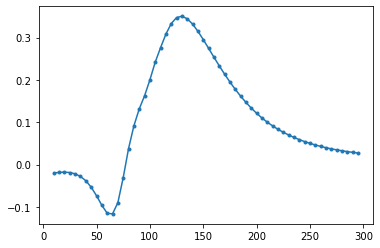

In [12]:
filename = 'ResNet16_bestmodel.pkl'
# filename = 'MNL0_bestmodel.pkl'

with open(filename, 'rb') as f:
    data = pickle.load(f)
    
model, config, model_stat = data

batch_size = config['batch_size']
# car:0, bike:1, transit:2, walk:3
mode = 4

dpdx = T.grad(model.output[:, mode].sum(axis=0), model.input, disconnected_inputs='ignore')
model.point_elastic = function(
    inputs=[],
    outputs=[dpdx, model.output],
    allow_input_downcast=True,
    givens={
        model.input: train_x_shared,
    },
)

x_in = train_x_data.iloc[:, 11].values
pnt_dydW, pnt_prob = model.point_elastic()

point_elasticity = pnt_dydW[:, 11] * x_in/pnt_prob[:, mode]
print('disaggregate point elasticity:', point_elasticity)

agg_point_elasticity = (point_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
print('aggregate point elasticity:', agg_point_elasticity)


list_agg_arc_el = []
for i in range(10, 300, 5):
    x_data_2 = raw_data.iloc[:, 1:-1]
    x_data_2.loc[:, 'trip_dist'] = x_data_2.loc[:, 'trip_dist'] * i/100.
    train_x_data_2, _ = x_data_2.iloc[:slice], x_data_2.iloc[slice:]
    train_y_data_2, _ = y_data.iloc[:slice], y_data.iloc[slice:]
    train_x_shared_2, _ = shared_dataset(train_x_data_2, train_y_data_2)

    model.arc_elastic = function(
        inputs=[],
        outputs=[dpdx, model.output],
        allow_input_downcast=True,
        givens={
            model.input: train_x_shared_2,
        },
    )

    arc_dydW, arc_prob = model.arc_elastic()
    # print(e_dydW, e_prob)
    x_in = train_x_data_2.iloc[:, 11].values # uncomment for point elasticities
    arc_elasticity = arc_dydW[:, 11] * x_in/pnt_prob[:, mode]
    # print('disaggregate arc elasticity:', arc_elasticity)

    agg_arc_elasticity = (arc_elasticity * pnt_prob[:, mode]/pnt_prob.mean(axis=0)[0]).mean()
    # print('aggregate point elasticity:', agg_arc_elasticity)
    list_agg_arc_el.append((i, agg_arc_elasticity))

print(list_agg_arc_el)

import matplotlib.pyplot as plt
plt.plot(*zip(*list_agg_arc_el), '.-')
plt.show()